# Expert model setup

In [1]:
!pip install huggingface_hub
!pip install dghs-imgutils
!pip install hbutils>=0.9.1
# opencv-python
# numpy

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 24.1
[notice] To update, run: pip install --upgrade pip
zsh:1: 0.9.1 not found


In [7]:
import cv2
import os.path
import numpy as np
from tqdm import tqdm
from typing import List, Tuple
from functools import lru_cache
from imgutils.data import ImageTyping
from imgutils.utils import open_onnx_model
from imgutils.detect import detection_visualize
from huggingface_hub import HfApi, HfFileSystem, hf_hub_download

In [9]:
hf_client = HfApi()
hf_fs = HfFileSystem()


@lru_cache()
def _get_available_models():
    for f in hf_fs.glob('deepghs/text_detection/*/end2end.onnx'):
        yield os.path.relpath(f, 'deepghs/text_detection').split('/')[0]


_ALL_MODELS = list(_get_available_models())
_DEFAULT_MODEL = 'dbnetpp_resnet50_fpnc_1200e_icdar2015'


@lru_cache()
def _get_onnx_session(model):
    return open_onnx_model(hf_hub_download(
        'deepghs/text_detection',
        f'{model}/end2end.onnx'
    ))


def _get_heatmap_of_text(image: ImageTyping, model: str) -> np.ndarray:
    origin_width, origin_height = width, height = image.size
    align = 32
    if width % align != 0:
        width += (align - width % align)
    if height % align != 0:
        height += (align - height % align)

    input_ = np.array(image).transpose((2, 0, 1)).astype(np.float32) / 255.0
    # noinspection PyTypeChecker
    input_ = np.pad(input_[None, ...], ((0, 0), (0, 0), (0, height - origin_height), (0, width - origin_width)))

    def _normalize(data, mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711)):
        mean, std = np.asarray(mean), np.asarray(std)
        return (data - mean[None, :, None, None]) / std[None, :, None, None]

    ort = _get_onnx_session(model)

    input_ = _normalize(input_).astype(np.float32)
    output_, = ort.run(['output'], {'input': input_})
    heatmap = output_[0]
    heatmap = heatmap[:origin_height, :origin_width]

    return heatmap


def _get_bounding_box_of_text(image: ImageTyping, model: str, threshold: float) \
        -> List[Tuple[Tuple[int, int, int, int], float]]:
    heatmap = _get_heatmap_of_text(image, model)
    c_rets = cv2.findContours((heatmap * 255.0).astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = c_rets[0] if len(c_rets) == 2 else c_rets[1]
    bboxes = []
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        x0, y0, x1, y1 = x, y, x + w, y + h
        score = heatmap[y0:y1, x0:x1].mean().item()
        if score >= threshold:
            bboxes.append(((x0, y0, x1, y1), score))

    return bboxes


def detect_text(image: ImageTyping, model: str = _DEFAULT_MODEL, threshold: float = 0.05):
    bboxes = []
    for (x0, y0, x1, y1), score in _get_bounding_box_of_text(image, model, threshold):
        bboxes.append(((x0, y0, x1, y1), 'text', score))
    return bboxes

In [13]:
from PIL import Image

image_path = f'./findit2/val/X51006555125.png'

# Load the original image
image = Image.open(image_path).convert('RGB')

In [15]:
model = _DEFAULT_MODEL
threshold = 0.05

In [17]:
detect_text(image, model, threshold)

end2end.onnx:   0%|          | 0.00/103M [00:00<?, ?B/s]

[((385, 957, 446, 977), 'text', 0.3020177483558655),
 ((260, 955, 383, 978), 'text', 0.25570428371429443),
 ((206, 955, 253, 974), 'text', 0.3339923620223999),
 ((136, 955, 202, 975), 'text', 0.36037278175354004),
 ((144, 929, 208, 946), 'text', 0.45202651619911194),
 ((260, 928, 444, 946), 'text', 0.3704589903354645),
 ((210, 928, 256, 946), 'text', 0.4093862473964691),
 ((476, 768, 518, 788), 'text', 0.11564271152019501),
 ((117, 766, 156, 788), 'text', 0.37624993920326233),
 ((57, 766, 85, 786), 'text', 0.21058864891529083),
 ((297, 765, 364, 785), 'text', 0.3886224031448364),
 ((108, 738, 200, 761), 'text', 0.20390763878822327),
 ((235, 736, 360, 754), 'text', 0.3995518386363983),
 ((430, 734, 518, 758), 'text', 0.18109078705310822),
 ((60, 730, 96, 754), 'text', 0.08608301728963852),
 ((500, 696, 552, 716), 'text', 0.1537872850894928),
 ((270, 695, 357, 711), 'text', 0.45703378319740295),
 ((498, 664, 554, 685), 'text', 0.3758138120174408),
 ((271, 662, 330, 681), 'text', 0.452733

In [19]:
_DEFAULT_MODEL

'dbnetpp_resnet50_fpnc_1200e_icdar2015'

# Forgery detection model setup

In [22]:
import os
import ast
import torch
import torchvision
import pandas as pd
from torchvision import models, transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from PIL import Image, ImageDraw
from skimage.transform import resize
import matplotlib.pyplot as plt

In [23]:
# Preprocessing: Convert bounding boxes to segmentation masks
def create_mask_from_bboxes(image_shape, annotations, detected_texts, num_classes):
    mask = Image.new('I', image_shape, 0)  # 'I' for integer mode
    draw = ImageDraw.Draw(mask)
    
#     # Example mapping, adjust according to your 'Entity type'
#     class_mapping = {'Forgery': 1}
    for box in detected_texts:
        draw.rectangle([box[0][0], box[0][1], box[0][2], box[0][3]], fill=1)
    
    if annotations != 0:
        for ann in annotations["regions"]:
            bbox = ann['shape_attributes']
            draw.rectangle([bbox['x'], bbox['y'], bbox['x'] + bbox['width'], bbox['y'] + bbox['height']], fill=2)
    
    # Ensure the mask is in the correct format for training
    mask = np.array(mask)
    mask = np.clip(mask, 0, num_classes-1)  # Ensure mask values are within [0, num_classes-1]
    return mask

In [24]:
# Custom Dataset
class SegmentationDataset(Dataset):
    def __init__(self, image_dir, annotations, transform=None):
        self.image_dir = image_dir
        self.annotations = annotations
        self.transform = transform
        # Set a common size for all images and masks
        self.resize = transforms.Resize((256, 256))

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        ann = self.annotations.iloc[idx]
        image_path = os.path.join(self.image_dir, ann['image'])
        image = Image.open(image_path).convert('RGB')
        mask = create_mask_from_bboxes(image.size, ann["forgery annotations"], 
                                       ann["detected_texts"], num_classes=3)
        
        if self.transform is not None:
            image = self.transform(image)
            mask = self.transform(mask)
        
        mask = np.array(mask, dtype=np.int64)  # Ensure mask is an integer type
        mask = torch.tensor(mask).squeeze(0)

        return image, mask

In [30]:
df = {}
for mode in ["train", "val", "test"]:
    df[mode] = pd.read_csv(f"./findit2/{mode}.txt")
    df[mode]["forgery annotations"] = df[mode]["forgery annotations"].map(ast.literal_eval)
    df[mode] = df[mode][df[mode]["image"].apply(lambda x: os.path.isfile(os.path.join(f"./findit2/{mode}", x)))]

## Generate auxiliary labels using expert model

In [33]:
def populate_text_detections(image_path):
    image = Image.open(image_path).convert('RGB')
    detected_texts = detect_text(image, _DEFAULT_MODEL, threshold)
    detected_texts_copy = []
    for i in range(len(detected_texts)):
        width = detected_texts[i][0][2] - detected_texts[i][0][0]
        height = detected_texts[i][0][3] - detected_texts[i][0][1]
        x1 = max(0, detected_texts[i][0][0]- int(0.1*width))
        x2 = min(image.size[0]-1, detected_texts[i][0][2]+ int(0.1*width))
        y1 = max(0, detected_texts[i][0][1]- int(0.4*height))
        y2 = min(image.size[1]-1, detected_texts[i][0][3]+ int(0.4*height))
        detected_texts_copy.append(((x1, y1, x2, y2), "text", detected_texts[i][2]))
    return detected_texts_copy

In [35]:
tqdm.pandas()

for k in df:
    df[k]["detected_texts"] = (f"./findit2/{k}/" + df[k]["image"]).progress_map(populate_text_detections)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [26:37<00:00,  7.33s/it]


## Instantiate PyTorch datasets and dataloaders

In [37]:
# Transform
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256)),

])

# Example annotations list (your dataset)
annotations = df["train"]

# Initialize dataset
tr_dataset = SegmentationDataset("./findit2/train", df["train"], transform=transform)
va_dataset = SegmentationDataset("./findit2/val", df["val"], transform=transform)
te_dataset = SegmentationDataset("./findit2/test", df["test"], transform=transform)

tr_dataloader = DataLoader(tr_dataset, batch_size=4, shuffle=True, drop_last=True)
va_dataloader = DataLoader(va_dataset, batch_size=4, shuffle=True, drop_last=True)
te_dataloader = DataLoader(te_dataset, batch_size=4, shuffle=True, drop_last=True)

## Define model

In [39]:
# Model
model = models.segmentation.deeplabv3_mobilenet_v3_large(pretrained=False, num_classes=3)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


class_frequencies = [1.2, 1.05, 1]  # Example frequencies for three classes

# Calculate weights
weights = 1.0 / torch.tensor(class_frequencies, dtype=torch.float32)


# Training essentials
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_function = torch.nn.CrossEntropyLoss(weight=weights)

/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


## Training model

In [41]:
# Training loop
num_epochs = 50  # Example, adjust as needed
tr_loss = []
va_loss = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(tr_dataloader):
        images, masks = images.to(device), masks.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = loss_function(outputs, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    tr_loss.append(running_loss / len(tr_dataloader))
    # Validation phase
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in va_dataloader:
            images, masks = images.to(device), masks.to(device)
            output = model(images)['out']
            loss = loss_function(output, masks)
            val_loss += loss.item()
    va_loss.append(val_loss / len(va_dataloader))
    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(tr_dataloader)}, Val Loss: {val_loss / len(va_dataloader)}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:05<00:00,  1.15it/s]


Epoch 1, Train Loss: 0.6690037399530411, Val Loss: 0.5358539645870527


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:02<00:00,  1.18it/s]


Epoch 2, Train Loss: 0.425995128436221, Val Loss: 0.4156324298431476


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:01<00:00,  1.19it/s]


Epoch 3, Train Loss: 0.37493085188584196, Val Loss: 0.39951476237426203


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:03<00:00,  1.17it/s]


Epoch 4, Train Loss: 0.3455024174311095, Val Loss: 0.359237726777792


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:03<00:00,  1.16it/s]


Epoch 5, Train Loss: 0.32832578745567137, Val Loss: 0.3443573492889603


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:03<00:00,  1.16it/s]


Epoch 6, Train Loss: 0.3180225383904245, Val Loss: 0.3367926984404524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:04<00:00,  1.16it/s]


Epoch 7, Train Loss: 0.31077781847367686, Val Loss: 0.3370936888580521


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:05<00:00,  1.15it/s]


Epoch 8, Train Loss: 0.3053912903285689, Val Loss: 0.33743856692065793


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:01<00:00,  1.19it/s]


Epoch 9, Train Loss: 0.29988149036135936, Val Loss: 0.3316264363626639


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:04<00:00,  1.16it/s]


Epoch 10, Train Loss: 0.296420035055942, Val Loss: 0.3335306973507007


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:03<00:00,  1.17it/s]


Epoch 11, Train Loss: 0.2940733236157232, Val Loss: 0.3314890305822094


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:02<00:00,  1.17it/s]


Epoch 12, Train Loss: 0.2893775238965948, Val Loss: 0.32699171515802544


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:02<00:00,  1.18it/s]


Epoch 13, Train Loss: 0.2859820770099759, Val Loss: 0.32640253007411957


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:33<00:00,  1.06s/it]


Epoch 14, Train Loss: 0.28326719544000095, Val Loss: 0.3247006107121706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [06:45<00:00,  2.82s/it]


Epoch 15, Train Loss: 0.28162931609484887, Val Loss: 0.3267449007059137


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [07:10<00:00,  2.99s/it]


Epoch 16, Train Loss: 0.27898997492674327, Val Loss: 0.3236766991515954


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [06:23<00:00,  2.67s/it]


Epoch 17, Train Loss: 0.2773737399321463, Val Loss: 0.32535084523260593


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [06:32<00:00,  2.72s/it]


Epoch 18, Train Loss: 0.27502475678920746, Val Loss: 0.3217038583631317


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [06:35<00:00,  2.74s/it]


Epoch 19, Train Loss: 0.2737228460609913, Val Loss: 0.3243161228795846


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [07:02<00:00,  2.93s/it]


Epoch 20, Train Loss: 0.2723111980077293, Val Loss: 0.3216552495335539


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [06:31<00:00,  2.72s/it]


Epoch 21, Train Loss: 0.2718547418092688, Val Loss: 0.32367786206305027


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [1:16:15<00:00, 31.77s/it]


Epoch 22, Train Loss: 0.27121186199494535, Val Loss: 0.3244735213617484


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:43<00:00,  1.40it/s]


Epoch 23, Train Loss: 0.26953734136703944, Val Loss: 0.3229198958724737


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 24, Train Loss: 0.26811374568690854, Val Loss: 0.32258835683266324


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:47<00:00,  1.34it/s]


Epoch 25, Train Loss: 0.2671920925171839, Val Loss: 0.32268821479131776


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:48<00:00,  1.33it/s]


Epoch 26, Train Loss: 0.2669611538036002, Val Loss: 0.32271495275199413


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:48<00:00,  1.32it/s]


Epoch 27, Train Loss: 0.2658862466406491, Val Loss: 0.3229115552579363


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:52<00:00,  1.28it/s]


Epoch 28, Train Loss: 0.2648412808775902, Val Loss: 0.3243762804195285


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:54<00:00,  1.26it/s]


Epoch 29, Train Loss: 0.26390324445027447, Val Loss: 0.32416161180784303


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.31it/s]


Epoch 30, Train Loss: 0.26349315518099403, Val Loss: 0.32499649686117965


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.31it/s]


Epoch 31, Train Loss: 0.26303833143578637, Val Loss: 0.32361203727001947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.31it/s]


Epoch 32, Train Loss: 0.2616244659034742, Val Loss: 0.32412622092912596


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:51<00:00,  1.29it/s]


Epoch 33, Train Loss: 0.26086563244462013, Val Loss: 0.3246708456426859


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:53<00:00,  1.27it/s]


Epoch 34, Train Loss: 0.2699562962063485, Val Loss: 0.3251648771887024


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.31it/s]


Epoch 35, Train Loss: 0.2699256971374982, Val Loss: 0.32806972072770196


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:51<00:00,  1.29it/s]


Epoch 36, Train Loss: 0.2631467948667705, Val Loss: 0.3267036738495032


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:50<00:00,  1.30it/s]


Epoch 37, Train Loss: 0.259467463940382, Val Loss: 0.32531663806488115


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:51<00:00,  1.29it/s]


Epoch 38, Train Loss: 0.2586977538238797, Val Loss: 0.3252085397640864


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [02:16<00:00,  1.05it/s]


Epoch 39, Train Loss: 0.2587374673328466, Val Loss: 0.3231961311151584


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:55<00:00,  1.25it/s]


Epoch 40, Train Loss: 0.25815100429786575, Val Loss: 0.32540081565578777


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:56<00:00,  1.24it/s]


Epoch 41, Train Loss: 0.25642476349862087, Val Loss: 0.3271585737044613


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:57<00:00,  1.23it/s]


Epoch 42, Train Loss: 0.2560287633807295, Val Loss: 0.3286717763791482


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:54<00:00,  1.25it/s]


Epoch 43, Train Loss: 0.2562683822276692, Val Loss: 0.3249128224949042


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:54<00:00,  1.26it/s]


Epoch 44, Train Loss: 0.255832358987795, Val Loss: 0.32464616000652313


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:58<00:00,  1.22it/s]


Epoch 45, Train Loss: 0.2551190455754598, Val Loss: 0.32676912440607947


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:55<00:00,  1.25it/s]


Epoch 46, Train Loss: 0.25450873204196495, Val Loss: 0.3299026076371471


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:55<00:00,  1.25it/s]


Epoch 47, Train Loss: 0.25433479104604984, Val Loss: 0.32813393386701745


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:53<00:00,  1.27it/s]


Epoch 48, Train Loss: 0.25402158747116727, Val Loss: 0.3278796663507819


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:51<00:00,  1.29it/s]


Epoch 49, Train Loss: 0.25358615246497923, Val Loss: 0.32751578992853564


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [01:51<00:00,  1.29it/s]


Epoch 50, Train Loss: 0.25405302048764294, Val Loss: 0.32891068638612825


## Evaluate model performance

In [43]:
def compute_iou(pred, target, threshold):
    pred = (pred > threshold).float()
    intersection = torch.logical_and(pred, target).float().sum((1, 2))
    union = torch.logical_or(pred, target).float().sum((1, 2))
    iou = (intersection / union)
    return iou.mean().item()

# Test set evaluation
test_loss = 0.0
iou_scores_set = []
threshold_range = np.arange(0, 1.01, 0.01)
model.eval()
with torch.no_grad():
    for images, masks in tqdm(te_dataloader):
        images, masks = images.to(device), masks.to(device)
        output = model(images)['out']
        loss = loss_function(output, masks)
        test_loss += loss.item()
        iou_scores = []
        output = torch.sigmoid(output)[:, 2, :, :]  # Apply sigmoid to get probabilities and select forged class
        for threshold in threshold_range:
            iou = compute_iou(output, masks, threshold)
            iou_scores.append(iou)
        iou_scores_set.append(iou_scores)

avg_iou = np.mean(iou_scores_set, axis=0)

print(f'Test Loss: {test_loss / len(te_dataloader)}')

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 54/54 [00:23<00:00,  2.29it/s]

Test Loss: 0.30705201073929117


### Plot train,validation and test losses

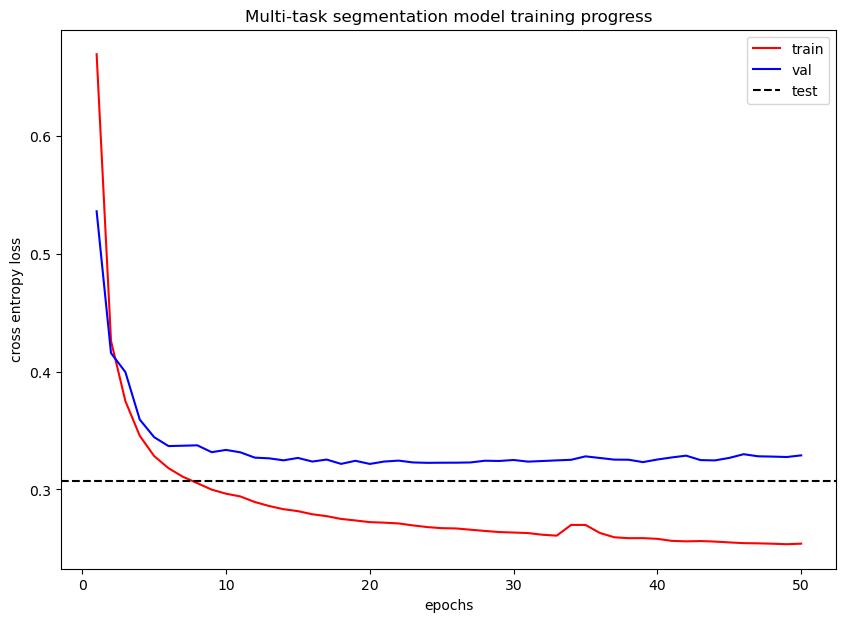

In [45]:
plt.figure(figsize=(10,7))
# Define the epochs and losses
epochs = list(range(1, 51))
plt.plot(epochs, tr_loss, 'r', label='train')
plt.plot(epochs, va_loss, 'b', label='val')
plt.axhline(test_loss / len(te_dataloader), color='black', linestyle='--', label='test') 
plt.ylabel("cross entropy loss")
plt.xlabel("epochs")
plt.title("Multi-task segmentation model training progress")
plt.legend()

### Plot IoU on test set

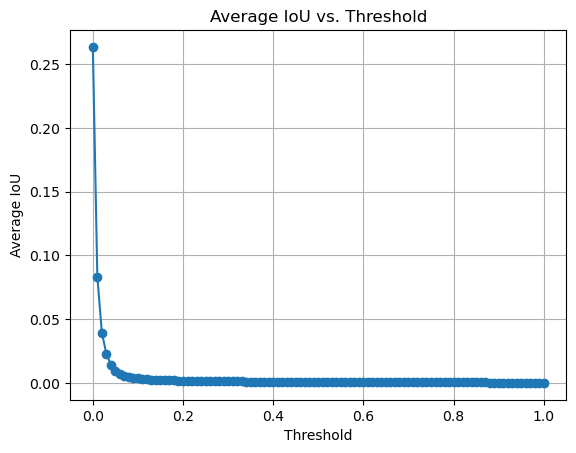

In [47]:
# Plotting the IoU curve
plt.plot(threshold_range, avg_iou, marker='o')
plt.xlabel('Threshold')
plt.ylabel('Average IoU')
plt.title('Average IoU vs. Threshold')
plt.grid(True)
plt.show()

## Interpret model predictions

In [49]:
mode = "test"

transform = T.Compose([
    T.Resize((256, 256)),
    # Don't convert to tensor yet to facilitate visualization steps
])

image_path = f'./findit2/test/X51005568866.png'
## image_path = f'./findit2/torchdataset/test/1/X51005757243.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557117.png'
# image_path = f'./findit2/torchdataset/test/1/X51006557195.png'
# image_path = f'./findit2/torchdataset/train/1/X51005365179.png'

# image_path = f'./findit2/torchdataset/test/0/X00016469619.png'

# Load the original image
original_image = Image.open(image_path).convert('RGB')
original_size = original_image.size  # Width, Height

# Apply the same transformations as during training (excluding ToTensor)
transformed_image = transform(original_image)  # Resized image

In [50]:
model.eval()  # Ensure the model is in evaluation mode
with torch.no_grad():
    input_tensor = T.functional.to_tensor(transformed_image).unsqueeze(0).to(device)  # Add batch dimension and transfer to GPU
    output = model(input_tensor)['out']
    predictions = torch.argmax(output.squeeze(), dim=0).detach().cpu().numpy()  # Convert to numpy array for visualization

In [51]:
predictions_prob = torch.softmax(output, dim=1)[0][2]
predictions_prob = np.array(predictions_prob, dtype=np.float32)

In [52]:
# Resize predictions back to the original image size
predictions_resized = resize(predictions_prob, (original_size[1], original_size[0]), 
                             order=0, preserve_range=True, anti_aliasing=False)


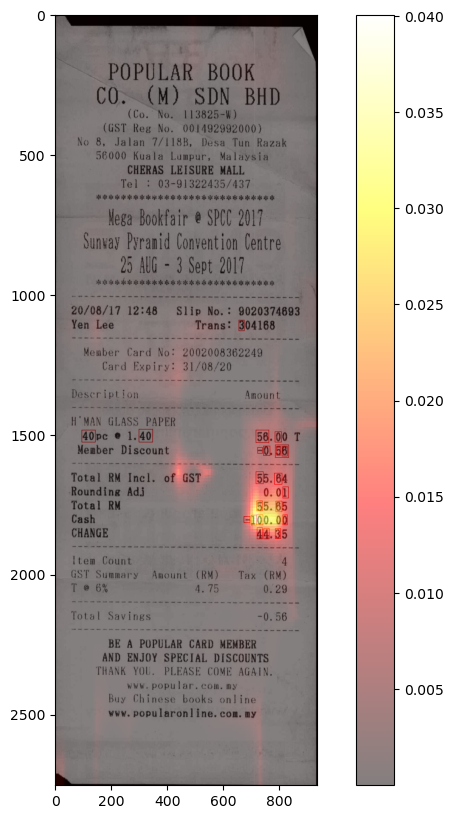

In [53]:
def draw_bounding_boxes(image, annotations):
    draw = ImageDraw.Draw(image)
    for ann in annotations.get('regions', []):
        shape_attr = ann['shape_attributes']
        x, y, w, h = shape_attr['x'], shape_attr['y'], shape_attr['width'], shape_attr['height']
        draw.rectangle([(x, y), (x+w, y+h)], outline="red", width=2)
    return image

annotations = df[mode][df[mode]["image"]==image_path.split("/")[-1]]["forgery annotations"].iloc[0]
if annotations ==0: 
    annotations={}

# Load the original image without resizing to maintain original dimensions for visualization
original_image = Image.open(image_path).convert('RGB')
drawn_image = draw_bounding_boxes(original_image, annotations)  # Assume 'annotations' is defined

# Convert drawn image to array for overlaying
import numpy as np
drawn_image_array = np.array(drawn_image)

# Create a figure to display the results
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Display original image
ax.imshow(drawn_image_array)
# Overlay heatmap (You may need to adjust the alpha for better visualization)
heatmap = ax.imshow(predictions_resized, cmap='hot', interpolation='nearest', alpha=0.5)
plt.colorbar(heatmap)
plt.show()